# CV Routine

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
# Load all necessary packages
import sys

import pandas as pd

sys.path.append("../")
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing
from aif360.algorithms.inprocessing.fairness_adjuster import FairnessAdjuster
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import (
    load_preproc_data_adult,
    load_preproc_data_compas,
    load_preproc_data_german,
)
from aif360.datasets import (
    AdultDataset,
    BinaryLabelDataset,
    CompasDataset,
    GermanDataset,
)
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector
from IPython.display import Markdown, display
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MaxAbsScaler, StandardScaler

from aif360.algorithms.inprocessing.xgb_fairness_adjuster import XGBFairnessAdjuster
from aif360.algorithms.inprocessing.xgb_adversarial_debiasing import (
    XGBAdversarialDebiasing,
)

tf.disable_eager_execution()

2025-01-08 12:33:07.064261: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-08 12:33:07.066448: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-08 12:33:07.096253: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-08 12:33:07.096287: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-08 12:33:07.096304: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [3]:
N_SEEDS = 10
SHOW_CI = False

In [4]:
dataset_orig = load_preproc_data_german(["age", "sex"])
privileged_groups = [{"age": 1}]
unprivileged_groups = [{"age": 0}]

In [5]:
import numpy as np

protected_attribute_name = list(unprivileged_groups[0].keys())[0]

In [6]:
from sklearn.model_selection import KFold, cross_val_score, cross_validate

min_max_scaler = MaxAbsScaler()

Prep

In [7]:
dataset_orig.features = min_max_scaler.fit_transform(dataset_orig.features)

CV

In [8]:
def get_metrics(
    dataset_orig_test, dataset_pred_test, unprivileged_groups, privileged_groups
):
    metric_dataset_debiasing_test = BinaryLabelDatasetMetric(
        dataset_orig_test,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups,
    )
    classified_metric_debiasing_test = ClassificationMetric(
        dataset_orig_test,
        dataset_pred_test,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups,
    )
    metrics_dict = {
        "Test Set: mean outcomes difference": metric_dataset_debiasing_test.mean_difference(),
        "Test Set: Classification accuracy": classified_metric_debiasing_test.accuracy(),
        "Test Set: Disparate impact": classified_metric_debiasing_test.disparate_impact(),
        "Test Set: Average odds difference": classified_metric_debiasing_test.average_odds_difference(),
    }
    return metrics_dict

In [9]:
from copy import copy, deepcopy

import numpy as np
from sklearn.metrics import accuracy_score  # Replace with desired metric
from sklearn.model_selection import KFold

protected_attribute_name = "age"


def cross_validate_seeds(
    model_class,
    model_kwargs,
    dataset,
    seeds=5,
    n_folds=5,
):
    """
    Runs cross-validation with multiple seeds.

    Parameters:
        model: The Scikit-learn model to validate.
        X: Feature matrix.
        y: Target vector.
        seeds: Number of seeds for cross-validation.
        folds: Number of folds for each cross-validation.

    Returns:
        results: Dictionary containing accuracy scores for each seed and fold.
    """
    results = {}
    original_df = dataset.convert_to_dataframe()[0]
    for seed in range(seeds):
        print(f"\nSeed {seed + 1}/{seeds}")
        kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
        seed_results = {}
        for to_debias in [True, False]:
            model_kwargs["debias"] = to_debias
            fold_results = []
            for fold, (train_idx, test_idx) in enumerate(kf.split(original_df)):
                # print(f"{seed=} || {fold=}")
                # Splitting data
                dataset_X_train, dataset_X_test = dataset.subset(
                    train_idx
                ), dataset.subset(test_idx)

                # Training model
                Z = dataset_X_train.protected_attributes[
                    :,
                    dataset_X_train.protected_attribute_names.index(
                        protected_attribute_name
                    ),
                ]
                model_kwargs["protected_group_vector"] = Z
                model = model_class(**model_kwargs)
                model.fit(dataset_X_train)

                # Making predictions
                dataset_preds = model.predict(dataset_X_test)

                # Evaluating model
                metrics = get_metrics(
                    dataset_X_test,
                    dataset_preds,
                    model_kwargs["unprivileged_groups"],
                    model_kwargs["privileged_groups"],
                )
                fold_results.append(metrics)

                # end session
            seed_results[f"{to_debias=}"] = fold_results
        results[f"Seed {seed}"] = seed_results

    return results

Fairness adjuster

In [10]:
model_class = XGBFairnessAdjuster
model_kwargs = {
    "privileged_groups": privileged_groups,
    "unprivileged_groups": unprivileged_groups,
    "adversary_loss_weight": 195,
    "seed": 1234,
}

In [11]:
results = cross_validate_seeds(
    model_class,
    model_kwargs,
    dataset_orig,
    seeds=N_SEEDS,
    n_folds=10,
)


Seed 1/10

Seed 2/10

Seed 3/10

Seed 4/10

Seed 5/10

Seed 6/10

Seed 7/10

Seed 8/10

Seed 9/10

Seed 10/10


In [12]:
import pickle

with open("./data/xgb_adjuster_group_cv_results.pickle", "wb") as path:
    pickle.dump(results, path, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
aggs = {}
for seed, res_dict in results.items():
    aggs[seed] = {}
    for to_debias, fold_res_dict in res_dict.items():
        res = pd.DataFrame(fold_res_dict).quantile([0.025, 0.975]).T
        res["means"] = pd.DataFrame(fold_res_dict).mean()

        if SHOW_CI:
            aggs[seed][to_debias] = res.apply(
                lambda x: f"{x.means:.4f} ({x[0.025]:.4f},{x[0.975]:.4f})", axis=1
            )
        else:
            aggs[seed][to_debias] = res.means

reform = {
    (outerKey, innerKey): values
    for outerKey, innerDict in aggs.items()
    for innerKey, values in innerDict.items()
}

adjuster_results = pd.DataFrame(reform).T
adjuster_results

Test Set: mean outcomes difference  \
Seed 0 to_debias=True                            -0.138795   
       to_debias=False                           -0.138795   
Seed 1 to_debias=True                            -0.155415   
       to_debias=False                           -0.155415   
Seed 2 to_debias=True                            -0.153424   
       to_debias=False                           -0.153424   
Seed 3 to_debias=True                            -0.148082   
       to_debias=False                           -0.148082   
Seed 4 to_debias=True                            -0.153232   
       to_debias=False                           -0.153232   
Seed 5 to_debias=True                            -0.142310   
       to_debias=False                           -0.142310   
Seed 6 to_debias=True                            -0.154448   
       to_debias=False                           -0.154448   
Seed 7 to_debias=True                            -0.151744   
       to_debias=False                           -0.151744   
Seed 8 to_debias=True                            -0.168477   
       to_debias=False                           -0.168477   
Seed 9 to_debias=True                            -0.159860   
       to_debias=False                           -0.159860   

                        Test Set: Classification accuracy  \
Seed 0 to_debias=True                               0.650   
       to_debias=False                              0.687   
Seed 1 to_debias=True                               0.652   
       to_debias=False                              0.688   
Seed 2 to_debias=True                               0.665   
       to_debias=False                              0.699   
Seed 3 to_debias=True                               0.668   
       to_debias=False                              0.701   
Seed 4 to_debias=True                               0.659   
       to_debias=False                              0.692   
Seed 5 to_debias=True                               0.658   
       to_debias=False                              0.698   
Seed 6 to_debias=True                               0.658   
       to_debias=False                              0.694   
Seed 7 to_debias=True                               0.661   
       to_debias=False                              0.693   
Seed 8 to_debias=True                               0.666   
       to_debias=False                              0.693   
Seed 9 to_debias=True                               0.656   
       to_debias=False                              0.689   

                        Test Set: Disparate impact  \
Seed 0 to_debias=True                     0.998935   
       to_debias=False                    0.642273   
Seed 1 to_debias=True                     1.065992   
       to_debias=False                    0.635326   
Seed 2 to_debias=True                     1.040681   
       to_debias=False                    0.654457   
Seed 3 to_debias=True                     1.050916   
       to_debias=False                    0.672024   
Seed 4 to_debias=True                     1.021150   
       to_debias=False                    0.646659   
Seed 5 to_debias=True                     1.066474   
       to_debias=False                    0.667942   
Seed 6 to_debias=True                     1.025287   
       to_debias=False                    0.630918   
Seed 7 to_debias=True                     1.042537   
       to_debias=False                    0.619352   
Seed 8 to_debias=True                     1.040261   
       to_debias=False                    0.663416   
Seed 9 to_debias=True                     1.009540   
       to_debias=False                    0.657861   

                        Test Set: Average odds difference  
Seed 0 to_debias=True                           -0.016772  
       to_debias=False                          -0.376956  
Seed 1 to_debias=True                            0.050915  
       to_debias=False                          -0.379981  
Seed

AD

In [14]:
model_class = XGBAdversarialDebiasing
model_kwargs = {
    "privileged_groups": privileged_groups,
    "unprivileged_groups": unprivileged_groups,
    "adversary_loss_weight": 10,
    "seed": 1234,
}

In [15]:
results = cross_validate_seeds(
    model_class,
    model_kwargs,
    dataset_orig,
    seeds=N_SEEDS,
    n_folds=10,
)


Seed 1/10

Seed 2/10

Seed 3/10

Seed 4/10

Seed 5/10

Seed 6/10

Seed 7/10

Seed 8/10

Seed 9/10

Seed 10/10


In [16]:
with open("./data/xgb_ad_group_cv_results.pickle", "wb") as path:
    pickle.dump(results, path, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
aggs = {}
for seed, res_dict in results.items():
    aggs[seed] = {}
    for to_debias, fold_res_dict in res_dict.items():
        res = pd.DataFrame(fold_res_dict).quantile([0.025, 0.975]).T
        res["means"] = pd.DataFrame(fold_res_dict).mean()

        if SHOW_CI:
            aggs[seed][to_debias] = res.apply(
                lambda x: f"{x.means:.4f} ({x[0.025]:.4f},{x[0.975]:.4f})", axis=1
            )
        else:
            aggs[seed][to_debias] = res.means

reform = {
    (outerKey, innerKey): values
    for outerKey, innerDict in aggs.items()
    for innerKey, values in innerDict.items()
}

ad_results = pd.DataFrame(reform).T
ad_results

Test Set: mean outcomes difference  \
Seed 0 to_debias=True                            -0.138795   
       to_debias=False                           -0.138795   
Seed 1 to_debias=True                            -0.155415   
       to_debias=False                           -0.155415   
Seed 2 to_debias=True                            -0.153424   
       to_debias=False                           -0.153424   
Seed 3 to_debias=True                            -0.148082   
       to_debias=False                           -0.148082   
Seed 4 to_debias=True                            -0.153232   
       to_debias=False                           -0.153232   
Seed 5 to_debias=True                            -0.142310   
       to_debias=False                           -0.142310   
Seed 6 to_debias=True                            -0.154448   
       to_debias=False                           -0.154448   
Seed 7 to_debias=True                            -0.151744   
       to_debias=False                           -0.151744   
Seed 8 to_debias=True                            -0.168477   
       to_debias=False                           -0.168477   
Seed 9 to_debias=True                            -0.159860   
       to_debias=False                           -0.159860   

                        Test Set: Classification accuracy  \
Seed 0 to_debias=True                               0.666   
       to_debias=False                              0.687   
Seed 1 to_debias=True                               0.665   
       to_debias=False                              0.688   
Seed 2 to_debias=True                               0.673   
       to_debias=False                              0.699   
Seed 3 to_debias=True                               0.668   
       to_debias=False                              0.701   
Seed 4 to_debias=True                               0.665   
       to_debias=False                              0.692   
Seed 5 to_debias=True                               0.670   
       to_debias=False                              0.698   
Seed 6 to_debias=True                               0.668   
       to_debias=False                              0.694   
Seed 7 to_debias=True                               0.660   
       to_debias=False                              0.693   
Seed 8 to_debias=True                               0.665   
       to_debias=False                              0.693   
Seed 9 to_debias=True                               0.662   
       to_debias=False                              0.689   

                        Test Set: Disparate impact  \
Seed 0 to_debias=True                     1.035066   
       to_debias=False                    0.642273   
Seed 1 to_debias=True                     1.047274   
       to_debias=False                    0.635326   
Seed 2 to_debias=True                     1.033360   
       to_debias=False                    0.654457   
Seed 3 to_debias=True                     1.029602   
       to_debias=False                    0.672024   
Seed 4 to_debias=True                     1.023790   
       to_debias=False                    0.646659   
Seed 5 to_debias=True                     1.057373   
       to_debias=False                    0.667942   
Seed 6 to_debias=True                     1.029156   
       to_debias=False                    0.630918   
Seed 7 to_debias=True                     1.028911   
       to_debias=False                    0.619352   
Seed 8 to_debias=True                     1.024051   
       to_debias=False                    0.663416   
Seed 9 to_debias=True                     1.022560   
       to_debias=False                    0.657861   

                        Test Set: Average odds difference  
Seed 0 to_debias=True                            0.027509  
       to_debias=False                          -0.376956  
Seed 1 to_debias=True                            0.035766  
       to_debias=False                          -0.379981  
Seed

In [18]:
adjuster_results

Test Set: mean outcomes difference  \
Seed 0 to_debias=True                            -0.138795   
       to_debias=False                           -0.138795   
Seed 1 to_debias=True                            -0.155415   
       to_debias=False                           -0.155415   
Seed 2 to_debias=True                            -0.153424   
       to_debias=False                           -0.153424   
Seed 3 to_debias=True                            -0.148082   
       to_debias=False                           -0.148082   
Seed 4 to_debias=True                            -0.153232   
       to_debias=False                           -0.153232   
Seed 5 to_debias=True                            -0.142310   
       to_debias=False                           -0.142310   
Seed 6 to_debias=True                            -0.154448   
       to_debias=False                           -0.154448   
Seed 7 to_debias=True                            -0.151744   
       to_debias=False                           -0.151744   
Seed 8 to_debias=True                            -0.168477   
       to_debias=False                           -0.168477   
Seed 9 to_debias=True                            -0.159860   
       to_debias=False                           -0.159860   

                        Test Set: Classification accuracy  \
Seed 0 to_debias=True                               0.650   
       to_debias=False                              0.687   
Seed 1 to_debias=True                               0.652   
       to_debias=False                              0.688   
Seed 2 to_debias=True                               0.665   
       to_debias=False                              0.699   
Seed 3 to_debias=True                               0.668   
       to_debias=False                              0.701   
Seed 4 to_debias=True                               0.659   
       to_debias=False                              0.692   
Seed 5 to_debias=True                               0.658   
       to_debias=False                              0.698   
Seed 6 to_debias=True                               0.658   
       to_debias=False                              0.694   
Seed 7 to_debias=True                               0.661   
       to_debias=False                              0.693   
Seed 8 to_debias=True                               0.666   
       to_debias=False                              0.693   
Seed 9 to_debias=True                               0.656   
       to_debias=False                              0.689   

                        Test Set: Disparate impact  \
Seed 0 to_debias=True                     0.998935   
       to_debias=False                    0.642273   
Seed 1 to_debias=True                     1.065992   
       to_debias=False                    0.635326   
Seed 2 to_debias=True                     1.040681   
       to_debias=False                    0.654457   
Seed 3 to_debias=True                     1.050916   
       to_debias=False                    0.672024   
Seed 4 to_debias=True                     1.021150   
       to_debias=False                    0.646659   
Seed 5 to_debias=True                     1.066474   
       to_debias=False                    0.667942   
Seed 6 to_debias=True                     1.025287   
       to_debias=False                    0.630918   
Seed 7 to_debias=True                     1.042537   
       to_debias=False                    0.619352   
Seed 8 to_debias=True                     1.040261   
       to_debias=False                    0.663416   
Seed 9 to_debias=True                     1.009540   
       to_debias=False                    0.657861   

                        Test Set: Average odds difference  
Seed 0 to_debias=True                           -0.016772  
       to_debias=False                          -0.376956  
Seed 1 to_debias=True                            0.050915  
       to_debias=False                          -0.379981  
Seed

,,Test Set: mean outcomes difference,Test Set: Classification accuracy,Test Set: Disparate impact,Test Set: Average odds difference
Seed 0,to_debias=True,-0.0,-2.402402,-3.490671,-160.969360
Seed 1,to_debias=True,-0.0,-1.954887,1.787293,42.356616
Seed 2,to_debias=True,-0.0,-1.188707,0.708441,19.534895
Seed 3,to_debias=True,-0.0,0.000000,2.070079,69.941492
Seed 4,to_debias=True,-0.0,-0.902256,-0.257865,-0.432880
Seed 5,to_debias=True,-0.0,-1.791045,0.860765,9.137991
Seed 6,to_debias=True,-0.0,-1.497006,-0.375980,2.363320
Seed 7,to_debias=True,-0.0,0.151515,1.324306,95.822793
Seed 8,to_debias=True,-0.0,0.150376,1.582880,76.021720
Seed 9,to_debias=True,-0.0,-0.906344,-1.273247,-57.717523


Test Set: mean outcomes difference    0.000000
Test Set: Classification accuracy    -1.034076
Test Set: Disparate impact            0.293600
Test Set: Average odds difference     9.605906
dtype: float64

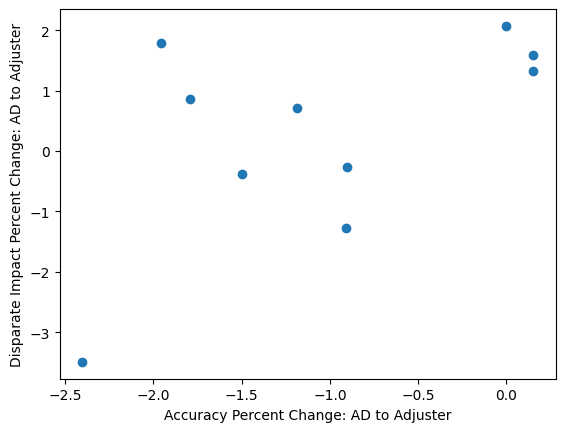

In [27]:
if not SHOW_CI:
    diffs = (adjuster_results - ad_results) / ad_results * 100
    diffs = diffs.loc[diffs.index.get_level_values(1) == "to_debias=True", :]
    display(diffs)
    display(diffs.mean(axis=0))

    plt.scatter(diffs["Test Set: Classification accuracy"], diffs["Test Set: Disparate impact"])
    plt.xlabel("Accuracy Percent Change: AD to Adjuster")
    plt.ylabel("Disparate Impact Percent Change: AD to Adjuster")
    plt.show()